# Workflow for porosity quantification

In this notebook we implement a simple segmentation routine for porosity quantification.

Workflow is mostly based on [scikit-image](https://scikit-image.org/docs/stable/auto_examples/) package.

You should run it sequentially and check quality of outputs at each step.

## Import packages

In [1]:
from pathlib import Path
from skimage.io import imread
from skimage.io import imshow
from skimage.exposure import rescale_intensity
from skimage.measure import find_contours
from skimage.filters import gaussian
from skimage.filters import threshold_otsu
import warnings
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Load and inspect initial image

Consider providing the relative or full path to target image.

In [2]:
# fname = "media/013-Image-Analysis-Porosity/500004.JPG"
# fname = "media/013-Image-Analysis-Porosity/700005.JPG"
fname = "media/013-Image-Analysis-Porosity/800009.JPG"

Image is loaded in gray-scale, *i.e.* as a 2-D array, for later thresholding.

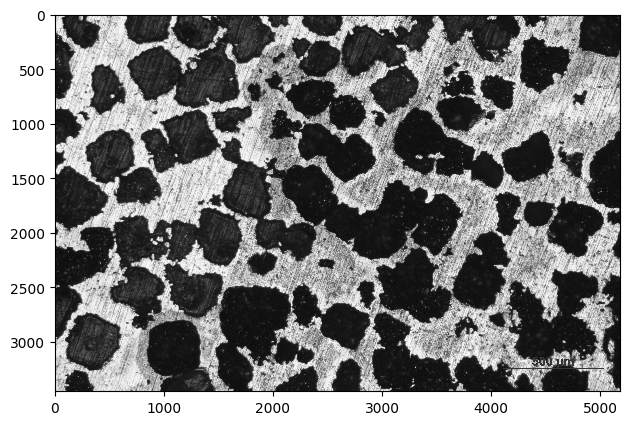

In [3]:
img0 = imread(fname, as_gray=True)
_ = imshow(img0)

## Blurring

Because of grinding and etching defects, it is important to apply an initial blur to the image.

You can control this by changing the value of `sigma`, the variance of the filter.

**NOTE:** the `sigma` value you choose here will impact the value of threshold `img_lo` you will use later. If Otsu automated thresholding works properly, you do not need to tweak this parameter and the associated `img_lo`. This is provided for cases where Otsu fails to automatically get pore boundaries.

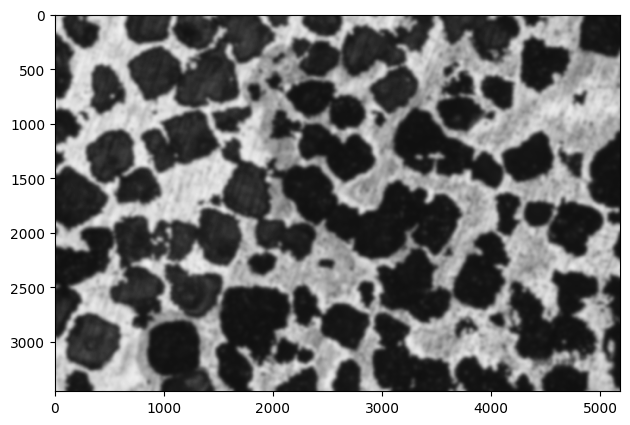

In [4]:
img1 = gaussian(img0, sigma=15)
_ = imshow(img1)

## Rescaling

Rescaling with standardize the range of image for later binary selection.

There is no need to tweak the next cell.

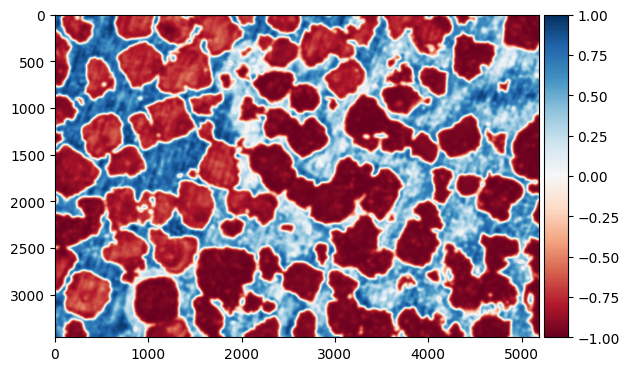

In [5]:
img2 = rescale_intensity(img1, out_range=(-1, 1))
_ = imshow(img2)

## Manual thresholding

Using a cut-off lower threshold we can capture the pores.

You need to manually edit parameter `img_lo`, which should be close to -1 because image intensity has been scaled to $I\in[-1,1]$.

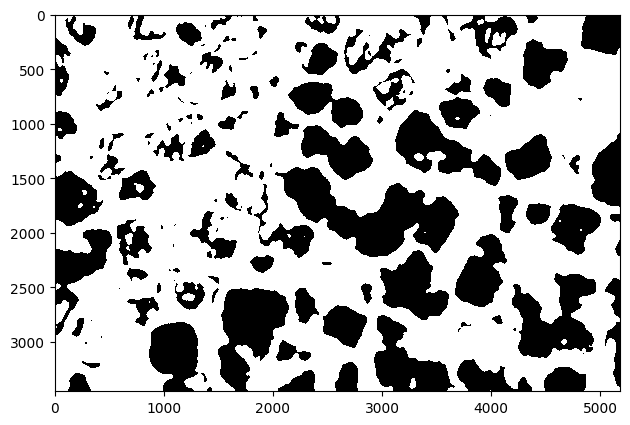

In [6]:
img_lo = -0.80

img3 = np.ones_like(img2)
img3[img2 < img_lo] = 0
_ = imshow(img3)

## Automatic thresholding

The following is based on this [example](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_thresholding.html#sphx-glr-auto-examples-segmentation-plot-thresholding-py) provided by scikit-image.

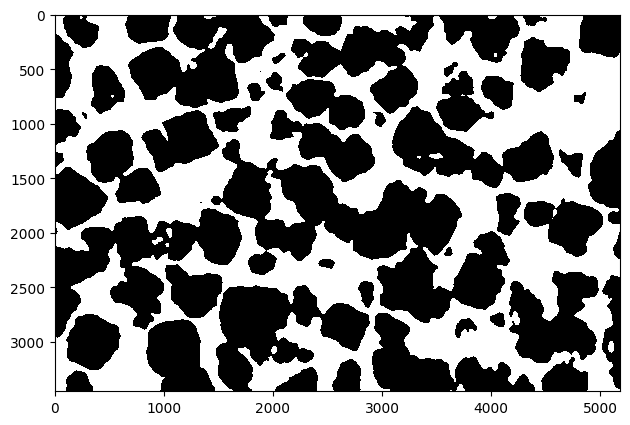

In [7]:
img4 = img1 > threshold_otsu(img1)
_ = imshow(img4)

## Validation and results

We find the countours of pores for display with the original image.

It is recommended you check the aspect to confirm the quality of results.

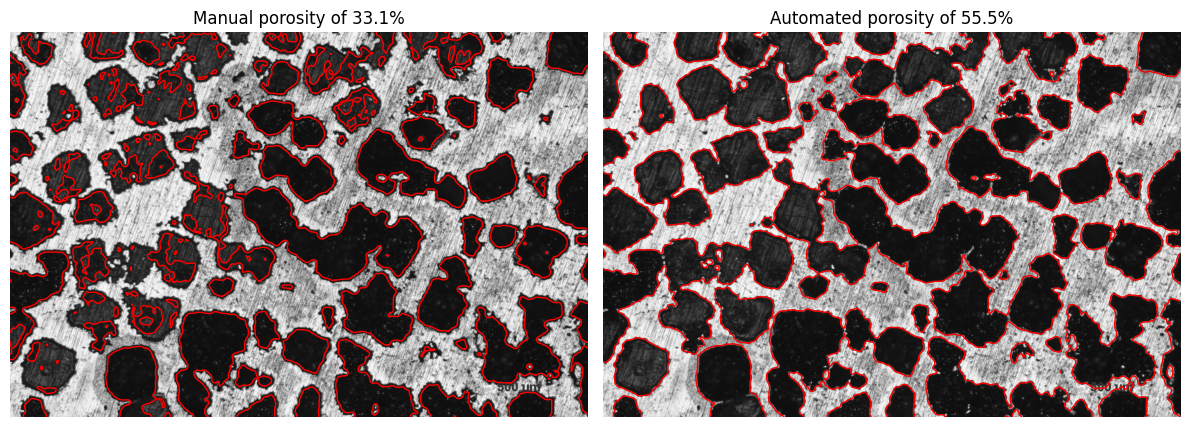

In [8]:
porosity_manu = 100 * (1 - img3.sum() / img0.size)
porosity_auto = 100 * (1 - img4.sum() / img0.size)

cmanu = find_contours(img3, 0.99)
cauto = find_contours(img4, 0.99)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].set_title(f"Manual porosity of {porosity_manu:.1f}%")
ax[1].set_title(f"Automated porosity of {porosity_auto:.1f}%")

ax[0].imshow(img0, cmap="gray")
ax[1].imshow(img0, cmap="gray")

for c in cmanu:
    ax[0].plot(c[:, 1], c[:, 0], color="r", linewidth=1)

for c in cauto:
    ax[1].plot(c[:, 1], c[:, 0], color="r", linewidth=1)

ax[0].axis("off")
ax[1].axis("off")

fig.tight_layout()
plt.savefig(f"{Path(fname).stem}-result.png")

## Wrap-up of automated workflow

In [9]:
def workflow(fname, sigma=15):
    """ Mostly automated quantification (play with sigma). """
    img0 = imread(fname, as_gray=True)
    img1 = gaussian(img0, sigma=sigma)
    img2 = rescale_intensity(img1, out_range=(-1, 1))
    img4 = img1 > threshold_otsu(img1)
    
    porosity = 100 * (1 - img4.sum() / img0.size)
    contours = find_contours(img4, 0.99)

    plt.close("all")
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    ax.set_title(f"Automated porosity of {porosity:.1f}%")
    ax.imshow(img0, cmap="gray")

    for c in contours:
        ax.plot(c[:, 1], c[:, 0], color="r", linewidth=1)

    ax.axis("off")
    fig.tight_layout()
    plt.savefig(f"{Path(fname).stem}-result-auto.png")
    plt.close("all")

In [10]:
all_files = Path("media/013-Image-Analysis-Porosity").glob("*.JPG")

for fname in all_files:
    workflow(fname)

Now it is time to go back to work!